# Distribute

Now that we have separated our problem, let's distribute the pieces.

We'll use [Dask.distributed](https://distributed.dask.org/) for distributed computing and [actors](https://distributed.dask.org/en/latest/actors.html).  More on actors [here](https://en.wikipedia.org/wiki/Actor_model).

## Create a Dask cluster

We'll have four workers with 1 thread each that will host different parts of our physical model.

In [1]:
from dask.distributed import Client

client = Client(n_workers=3, threads_per_worker=1, memory_limit=1e9)
client

Client Scheduler: tcp://127.0.0.1:49734 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 3 Memory: 3.00 GB


## Space, particles, and random numbers

The following is largely identical to what we did in [02_separation-Copy1.ipynb](02_separation-Copy1.ipynb).

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

The spatial domain doesn't call anything.  It's identical to the earlier implementation.

In [3]:
class PeriodicSpace:
    def __init__(self, length_x=10, length_y=20):
        self.length_y = length_y
        self.length_x = length_x
    
    def get_sizes(self):
        return self.length_x, self.length_y
        
    def normalize_positions(self, x, y):
        return np.mod(x, self.length_x), np.mod(y, self.length_y)

Each particle calls the spatial domain.  In distributed mode, we'll have to make sure that we get the `.result()` from the [`Future` objects](https://docs.python.org/3/library/concurrent.futures.html#future-objects) returned when calling methods on actors.

In [4]:
class Particles:
    def __init__(
        self,
        rng=np.random.RandomState(),
        space=PeriodicSpace(),
        x=None, y=None,
        step_length=0.5
    ):
        self.rng = rng
        self.space = space
        self.x, self.y = x, y
        self.step_length = step_length
        self.steps_done = 0

    def move(self):
        self.x += self.step_length * self.rng.normal(size=self.x.shape).result()
        self.y += self.step_length * self.rng.normal(size=self.y.shape).result()
        
        self.x, self.y = self.space.normalize_positions(self.x, self.y).result()
        
        self.steps_done += 1

    def center_of_mass(self):
        return self.x.mean(), self.y.mean()
    
    def moment_of_inertia(self):
        return self.x.var() + self.y.var()

    def diagnostics(self):
        com = self.center_of_mass()
        mi = self.moment_of_inertia()
        return pd.DataFrame(
            {
                "center_of_mass_x": com[0],
                "center_of_mass_y": com[1],
                "moment_of_inertia": mi
            },
            index=[self.steps_done, ],        
        )
    
    def positions(self):
        return pd.DataFrame(
            {
                "x": self.x,
                "y": self.y
            }
        )

## Submit space, rng and group of particles to the cluster

In [5]:
space = client.submit(
    PeriodicSpace,
    length_x=10,
    length_y=20,
    actor=True,
    pure=False
).result()

In [6]:
rng = client.submit(
    np.random.RandomState, actor=True, pure=False
).result()

In [8]:
length_x, length_y = space.get_sizes().result()
particles = client.submit(
    Particles, space=space, rng=rng,
    x=np.ones((10_000, )) * length_x / 2.0,
    y=np.ones((10_000, )) * length_y / 2.0,
    actor=True, pure=False
).result()

## Plot initial positions

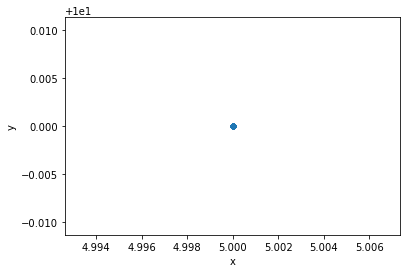

In [9]:
particles.positions().result().plot.scatter(x="x", y="y");

## Run the main loop

In [10]:
diags = particles.diagnostics().result()
    
for step in range(1, 1000):
    particles.move().result()

    diags = diags.append(
        particles.diagnostics().result()
    )

## Plot data

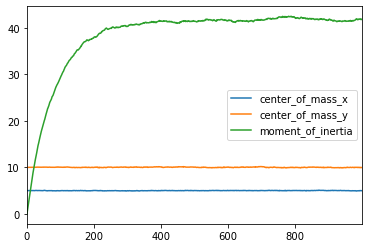

In [11]:
diags.plot();

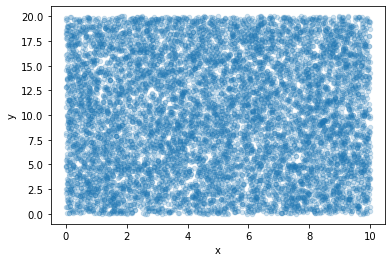

In [12]:
particles.positions().result().plot.scatter(x="x", y="y", alpha=0.2);